In [150]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

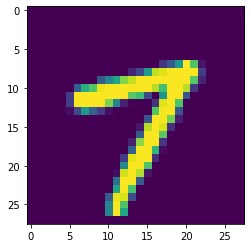

In [151]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

### Целевое значение
next(iter(train_dataloader))[1]

### Torch tensor
next(iter(train_dataloader))[0].shape

for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Нейронная сеть должна решать задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)

In [152]:
class IsSoftmax(torch.nn.Module):
    def __init__(self, num_features, num_classes):#input_shape=(1,28,28)
        super(IsSoftmax, self).__init__()
        self.Linear1 = torch.nn.Linear(num_features, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 32)
        self.Linear4 = torch.nn.Linear(32, num_classes)
        self.relu = torch.nn.ReLU()
        #self.Sigmoid = torch.nn.Sigmoid()
        self.Softmax = torch.nn.Softmax()
        self.dropout = torch.nn.Dropout(0.3)
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.dropout(x) #Dropout — решает проблему переобучения и повышает точность классиф. модели!
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)
        x = self.relu(x)
        probas = self.Linear4(x).squeeze(1)
        x = self.Softmax(probas) #dim=1
        return x, probas


model = IsSoftmax(num_features=784, num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

IsSoftmax(
  (Linear1): Linear(in_features=784, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=64, bias=True)
  (Linear3): Linear(in_features=64, out_features=32, bias=True)
  (Linear4): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (Softmax): Softmax(dim=None)
  (dropout): Dropout(p=0.3, inplace=False)
)

### Функция, вычисляющая лосс

In [153]:
def loss_function(true, pred):
    loss = torch.nn.CrossEntropyLoss()
    return loss(pred, true)

### Оптимизатор

In [154]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [156]:
import time
import torch.nn.functional as F
torch.manual_seed(123)

NUM_EPOCHS = 30
WANTED_LABEL = 9

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

start_time = time.time()
epoch_costs = []
for epoch in range(NUM_EPOCHS):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_dataloader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
            
        ### Обучение (прямое и обратн. распространение ошибки)
        logits, probas = model(features)
        
        # Кроссэнтропия
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        ### Обновление параметров модели
        optimizer.step()
        
        ### Вывод лога
        if not batch_idx % 50: ''''''
            #print ('Эпоха: %03d/%03d | Batch %03d/%03d | Cost: %.4f' %(epoch+1, NUM_EPOCHS, batch_idx, len(train_dataset)//BATCH_SIZE, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        #print('Эпоха: %03d/%03d Точность: %.2f%%' % (epoch+1, NUM_EPOCHS, compute_accuracy(model, train_dataloader)))
        #print('Время прошло: %.2f min' % ((time.time() - start_time)/60))

#Вывод общей точности классификации модели
print('\n Точность классификации модели: %.2f%%' % (compute_accuracy(model, test_dataloader)))

<ipython-input-152-ce1c84f86c34>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.Softmax(probas) #dim=1



 Точность классификации модели: 9.60%



 Числа кторые необходимо распознать:: 


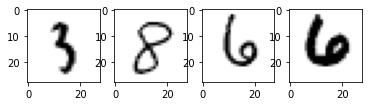


 Числа кторые были распознаны сетью:: 
Predicted labels tensor([6, 6, 6, 6])

 Вывод метрик:: 
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         2
           8       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.17      0.33      0.22         4
weighted avg       0.25      0.50      0.33         4



<ipython-input-152-ce1c84f86c34>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.Softmax(probas) #dim=1
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

In [162]:
for features, targets in test_dataloader:
    break
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)
print("\n Числа кторые необходимо распознать:: ")
plt.show()

print("\n Числа кторые были распознаны сетью:: ")
_, predictions = model.forward(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

print("\n Вывод метрик:: ")
from sklearn.metrics import classification_report
#accuracy_score(preds, reals), f1_score(reals, preds)
print(classification_report(targets[:4], predictions))
#print(classification_report(reals, preds, labels=[1, 2, 3]))